# Testing co-location rate and spatial co-location rate

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from colocation.wang_colocation import WangColocation
from scipy.special import expit

## Functions

In [2]:
def find_col(user1: pd.DataFrame, user2: pd.DataFrame) -> pd.DataFrame:
    matching = user1.merge(user2, on=["x", "y", "time"])
    return matching

In [3]:
def find_scol(user1: pd.DataFrame, user2: pd.DataFrame) -> pd.DataFrame:
    matching = user1.merge(user2, on=["x", "y"])
    return matching

In [4]:
def make_traj_3d(plotting_data: pd.DataFrame, save_path: str = "",
                 calculate_scol: bool = False, 
                 calculate_col: bool = True) -> None:
    fig1 = px.line_3d(plotting_data, x="x", y="y", z="time", color="userID")

    user_x = plotting_data.loc[plotting_data["userID"]=="x", :]
    user_y = plotting_data.loc[plotting_data["userID"]=="y", :]

    col = find_col(user_x, user_y) if calculate_col else []
    scol = find_scol(user_x, user_y) if calculate_scol else []

    d = fig1.data

    if len(col) > 0:
        fig2 = px.scatter_3d(col, x="x", y="y", z="time", opacity=0.5)
        d = d + fig2.data
    if len(scol) > 0:
        fig3 = px.scatter_3d(scol, x="x", y="y", z="time_x", opacity=0.5)
        fig4 = px.scatter_3d(scol, x="x", y="y", z="time_y", opacity=0.5)
        d = d + fig3.data + fig4.data
    
    fig = go.Figure(data = d)

    camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
        
    fig.update_layout(scene=dict(xaxis_title="x",
                                 yaxis_title="y",
                                 zaxis_title="time"),
                      scene_camera=camera,
                      margin=dict(l=5, r=5, t=5, b=5),
                      width=600, height=600)

    if save_path.endswith(".html"):
        fig.write_html(save_path)
    if save_path.endswith(".pdf"):
        fig.write_image(save_path)

    return fig

In [5]:
def make_traj_animation(plotting_data: pd.DataFrame, save_path: str= "") -> None:
    xs = plotting_data["x"]
    ys = plotting_data["y"]
    fig = px.scatter(plotting_data, x="x", y="y",
                 animation_frame="time", animation_group="userID", color="userID",
                 range_x=[min(xs), max(xs)], range_y=[min(ys), max(ys)])

    if save_path.endswith(".html"):
        fig.write_html(save_path)

    fig.show()

In [6]:
def curve(row):
    x = row["x"]
    numerator = 1
    denominator = 1 + (x/(1-x))**(-1)
    return numerator / denominator

## Create datasets

## Dataset 1

For this dataset, there are two individuals.
Observations are collected for both individuals at every timestep.
The individuals cross paths once, i.e. at one specific timestep, they share the same location.
In this case, we would like for our colocation identification system to correctly identify this instance of colocation, and not identify any others.
For ease, the two individuals will move linearly across a square environment.

In [7]:
x_data = [{"userID": "x", "x": i, "y": i, "time": i} for i in range(10)]
y_data = [{"userID": "y", "x": i, "y": 10-i, "time": i} for i in range(10)]
data = x_data + y_data
data = pd.DataFrame(data)

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


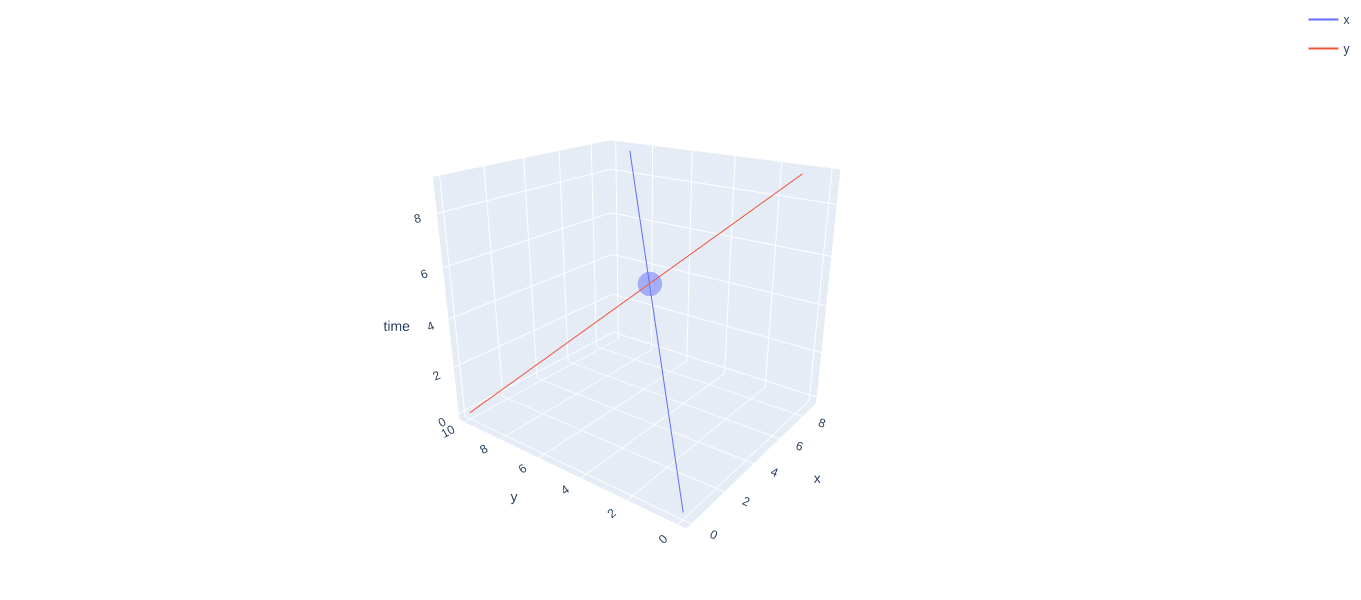

In [8]:
fig = make_traj_3d(data, save_path="figures/plotly_trajectory.pdf")
fig.show()

In [9]:
data.to_csv("data/data1.csv", index=False)

## Dataset 2

This dataset will be similar to the previous dataset.
In this dataset, however, the individuals will not move as linearly.

In [10]:
x_data = [{"userID": "x", "x": 0, "time": 0, "y": 0},
          {"userID": "x", "x": 1, "time": 1, "y": 0.5},
          {"userID": "x", "x": 2, "time": 2, "y": 1},
          {"userID": "x", "x": 3, "time": 3, "y": 2},
          {"userID": "x", "x": 4, "time": 4, "y": 4},
          {"userID": "x", "x": 5, "time": 5, "y": 5},
          {"userID": "x", "x": 6, "time": 6, "y": 7},
          {"userID": "x", "x": 7, "time": 7, "y": 8},
          {"userID": "x", "x": 8, "time": 8, "y": 8.5},
          {"userID": "x", "x": 9, "time": 9, "y": 9},
          {"userID": "x", "x": 10, "time": 10, "y": 10}]

x_data = pd.DataFrame(x_data)

y_data = x_data.copy()
y_data["userID"] = "y"
y_data["y"] = max(x_data["y"]) - x_data["y"]

data = pd.concat([x_data, y_data])

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



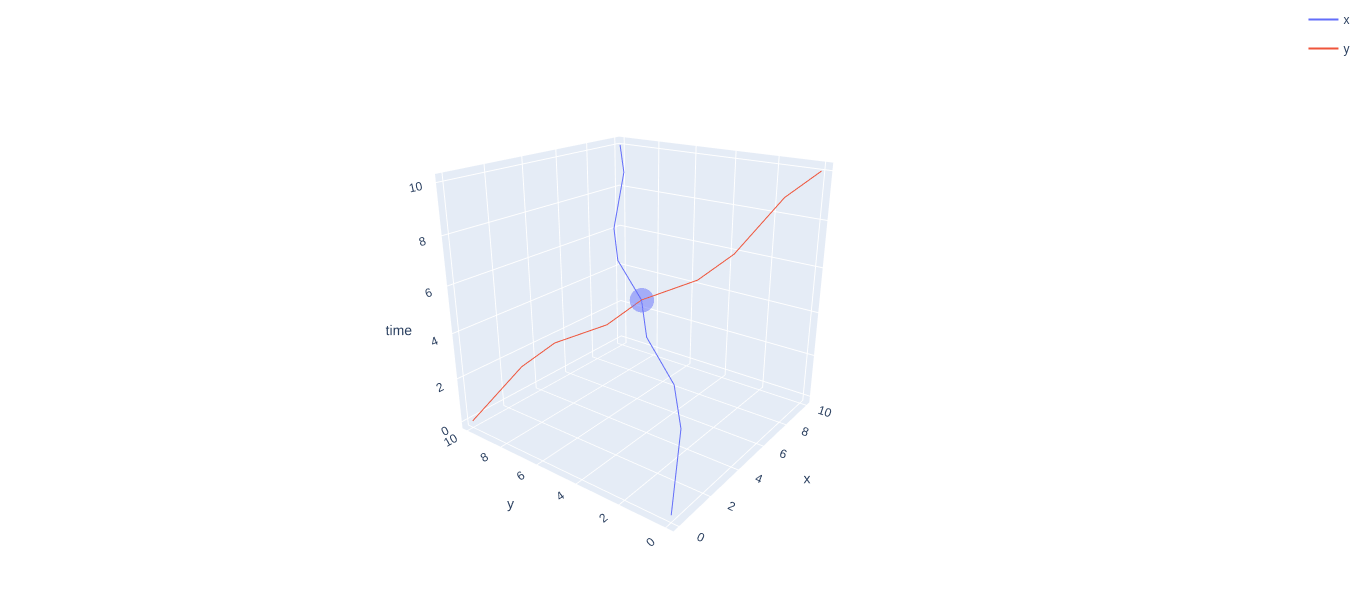

In [11]:
fig = make_traj_3d(data)
fig.show()

In [12]:
data.to_csv("data/data2.csv", index=False)

## Dataset 3

This dataset will be similar to Dataset 2, but data will not be collected with uniform frequency for each of the individauls.
This is achieved by taking a random sample of the overall data (but could also be achieved by taking a random sample of the constituent data for each of the individuals).

In [13]:
x_data = [{"userID": "x", "x": 0, "time": 0, "y": 0},
          {"userID": "x", "x": 1, "time": 1, "y": 0.5},
          {"userID": "x", "x": 2, "time": 2, "y": 1},
          {"userID": "x", "x": 3, "time": 3, "y": 2},
          {"userID": "x", "x": 4, "time": 4, "y": 4},
          {"userID": "x", "x": 5, "time": 5, "y": 5},
          {"userID": "x", "x": 6, "time": 6, "y": 7},
          {"userID": "x", "x": 7, "time": 7, "y": 8},
          {"userID": "x", "x": 8, "time": 8, "y": 8.5},
          {"userID": "x", "x": 9, "time": 9, "y": 9},
          {"userID": "x", "x": 10, "time": 10, "y": 10}]

x_data = pd.DataFrame(x_data)

y_data = x_data.copy()
y_data["userID"] = "y"
y_data["y"] = max(x_data["y"]) - x_data["y"]

data = pd.concat([x_data, y_data])

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



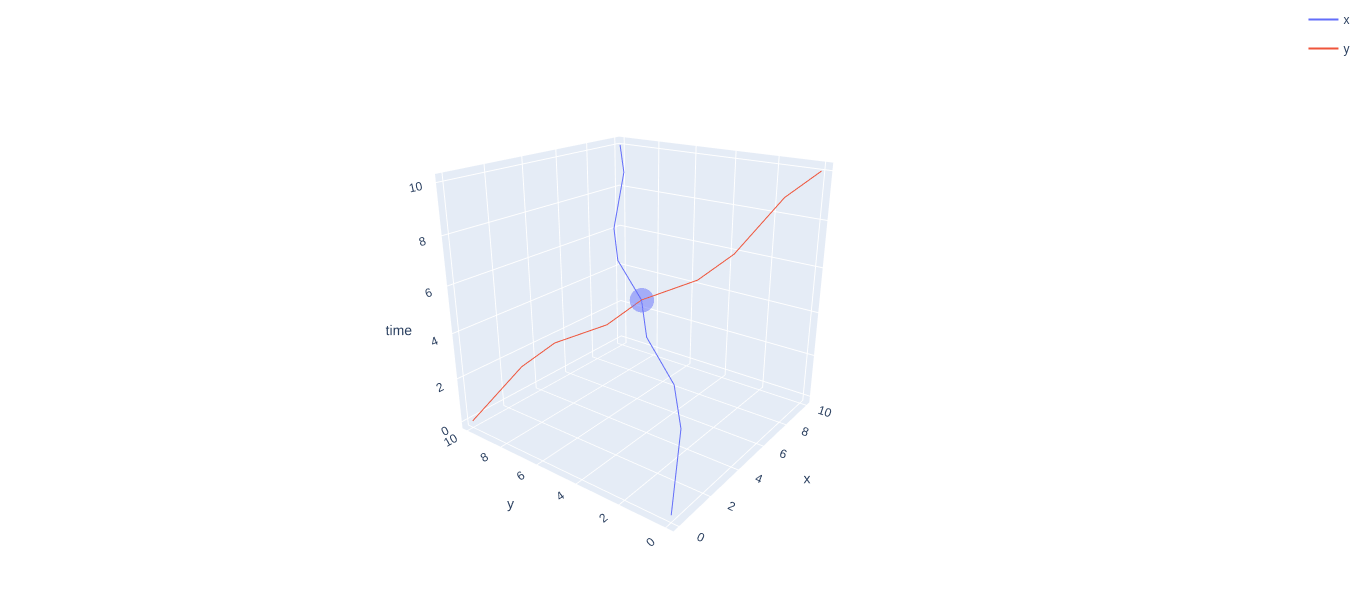

In [14]:
fig = make_traj_3d(data)
fig.show()

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



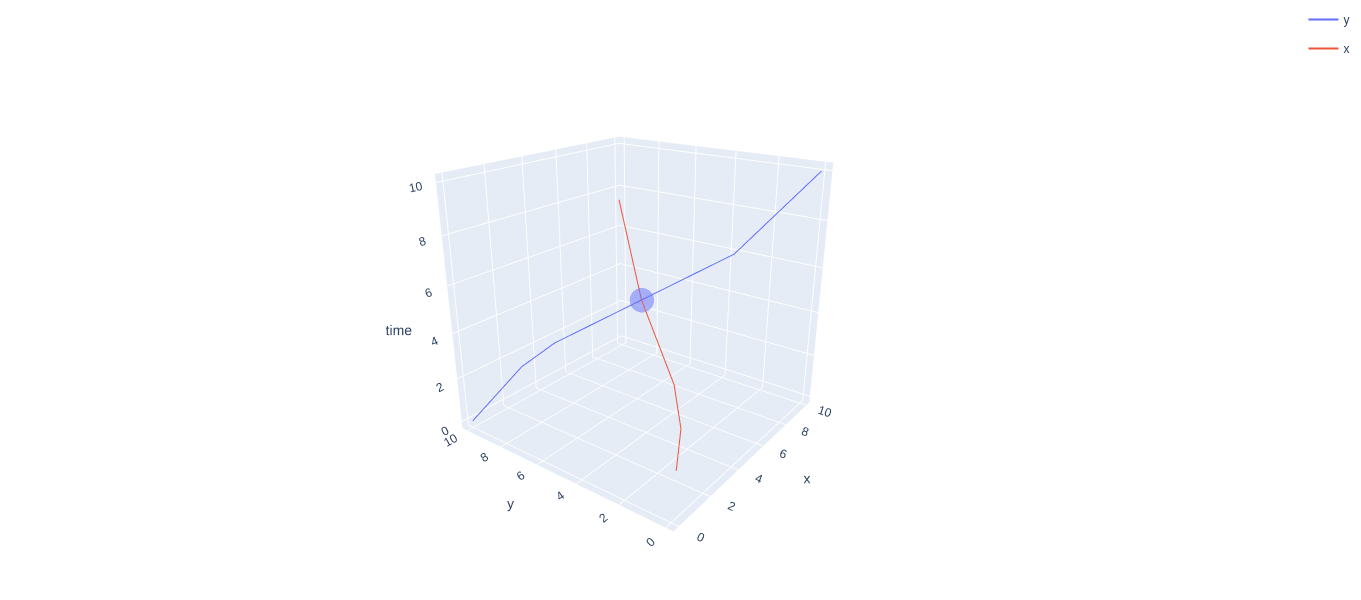

In [15]:
data = data.sample(frac=0.5).sort_index()
fig = make_traj_3d(data)
fig.show()

In [16]:
data.to_csv("data/data3.csv", index=False)

## Dataset 4

This dataset will collect data with uniform frequency.
However, instead of collecting $x-y$ coordinates for the individuals, the data will consist of specific location IDs and each location ID will have a given set of $x-y$ coordinates.

In [17]:
locations = [{"locationID": "0", "x": 0, "y": 0},
             {"locationID": "1", "x": 4, "y": 2},
             {"locationID": "2", "x": 6, "y": 8},
             {"locationID": "3", "x": 14, "y": 4},
             {"locationID": "4", "x": 8, "y": 16},
             {"locationID": "5", "x": 2, "y": 10},
             {"locationID": "6", "x": 16, "y": 20},
             {"locationID": "7", "x": 10, "y": 14},
             {"locationID": "8", "x": 18, "y": 6}]
locations = pd.DataFrame(locations)
locations.head()

locationID   x   y
0          0   0   0
1          1   4   2
2          2   6   8
3          3  14   4
4          4   8  16

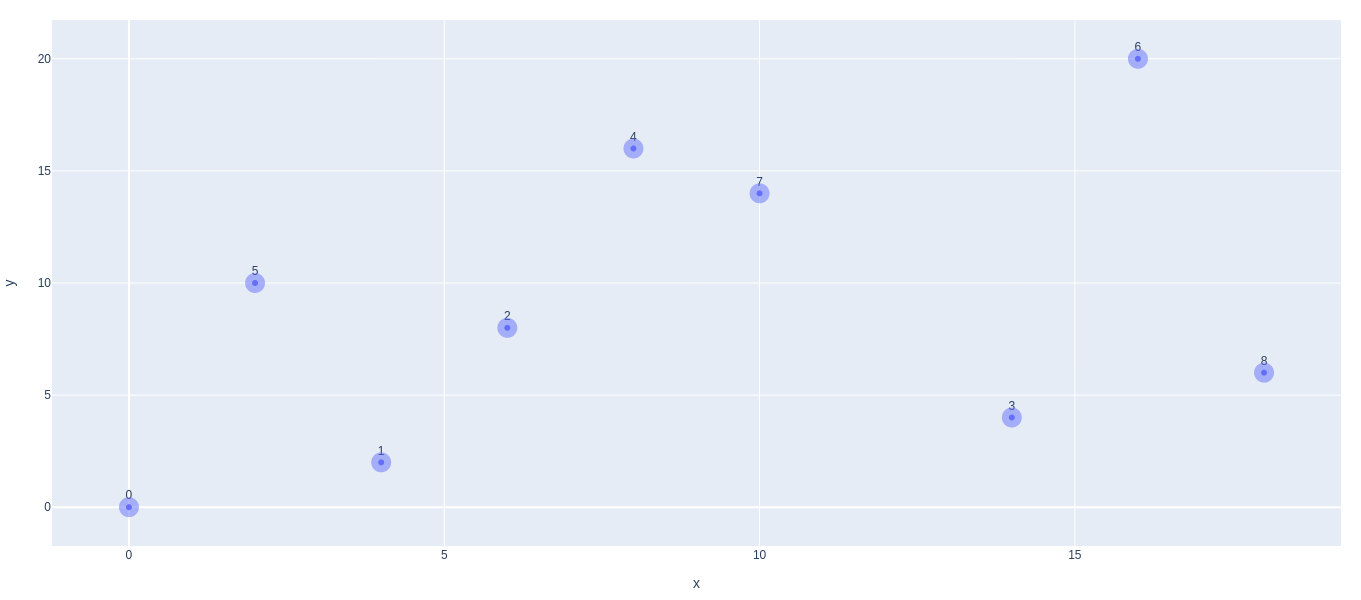

In [18]:
fig1 = px.scatter(locations,
                  x="x", y="y", 
                  text="locationID")
fig2 = px.scatter(locations,
                  x="x", y="y",
                  opacity=0.5)
fig2.update_traces(marker=dict(size=20))
fig = go.Figure(data=fig1.data+fig2.data)
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), 
                  width=600, height=600,
                  xaxis_title="x",
                  yaxis_title="y")
fig.update_traces(textposition="top center")
fig.show()
fig.write_image("figures/sensor_locations.pdf")

In [19]:
locations.to_csv("data/locations.csv", index=False)

In [20]:
data = [{"userID": "x", "locationID": "0", "time": 0},
        {"userID": "y", "locationID": "0", "time": 0},
        {"userID": "x", "locationID": "1", "time": 5},
        {"userID": "y", "locationID": "1", "time": 6},
        {"userID": "x", "locationID": "2", "time": 8},
        {"userID": "y", "locationID": "4", "time": 10},
        {"userID": "x", "locationID": "6", "time": 11},
        {"userID": "y", "locationID": "3", "time": 12},
        {"userID": "x", "locationID": "3", "time": 15},
        {"userID": "y", "locationID": "1", "time": 15},
        {"userID": "y", "locationID": "7", "time": 18},
        {"userID": "x", "locationID": "0", "time": 20},
        {"userID": "y", "locationID": "8", "time": 20},
        {"userID": "x", "locationID": "0", "time": 22},
        {"userID": "x", "locationID": "3", "time": 25}]
data = pd.DataFrame(data)
data.head()

userID locationID  time
0      x          0     0
1      y          0     0
2      x          1     5
3      y          1     6
4      x          2     8

In [21]:
data.to_csv("data/data.csv", index=False)

## Plot trajectories

In [22]:
plotting_data = pd.merge(left=data, right=locations, on="locationID", how="left")
plotting_data.head()

userID locationID  time  x  y
0      x          0     0  0  0
1      y          0     0  0  0
2      x          1     5  4  2
3      y          1     6  4  2
4      x          2     8  6  8

In [23]:
plotting_data

userID locationID  time   x   y
0       x          0     0   0   0
1       y          0     0   0   0
2       x          1     5   4   2
3       y          1     6   4   2
4       x          2     8   6   8
5       y          4    10   8  16
6       x          6    11  16  20
7       y          3    12  14   4
8       x          3    15  14   4
9       y          1    15   4   2
10      y          7    18  10  14
11      x          0    20   0   0
12      y          8    20  18   6
13      x          0    22   0   0
14      x          3    25  14   4

In [24]:
user_x = plotting_data.loc[plotting_data["userID"]=="x", :]
user_y = plotting_data.loc[plotting_data["userID"]=="y", :]

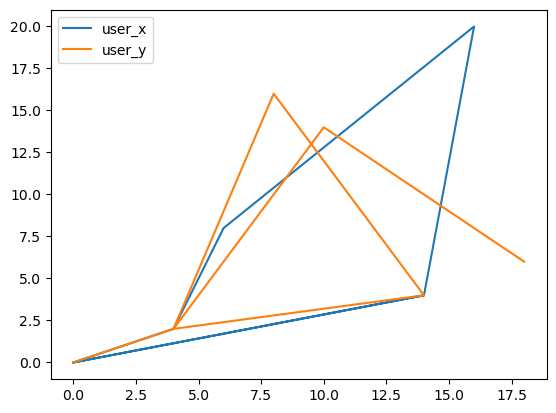

In [25]:
plt.figure()
plt.plot(user_x["x"], user_x["y"], label="user_x")
plt.plot(user_y["x"], user_y["y"], label="user_y")
plt.legend()
plt.savefig("figures/trajectories_2d.pdf")
plt.show()

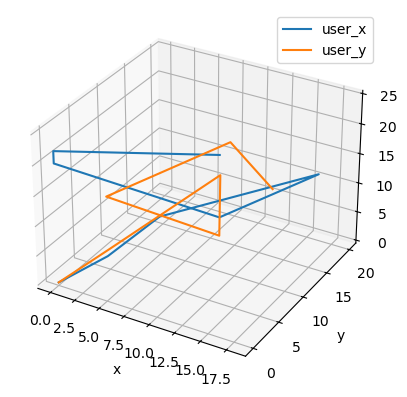

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot(user_x["x"], user_x["y"], zs=user_x["time"], label="user_x")
ax.plot(user_y["x"], user_y["y"], zs=user_y["time"], label="user_y")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")

plt.savefig("figures/trajectories_3d.pdf")

plt.show()

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



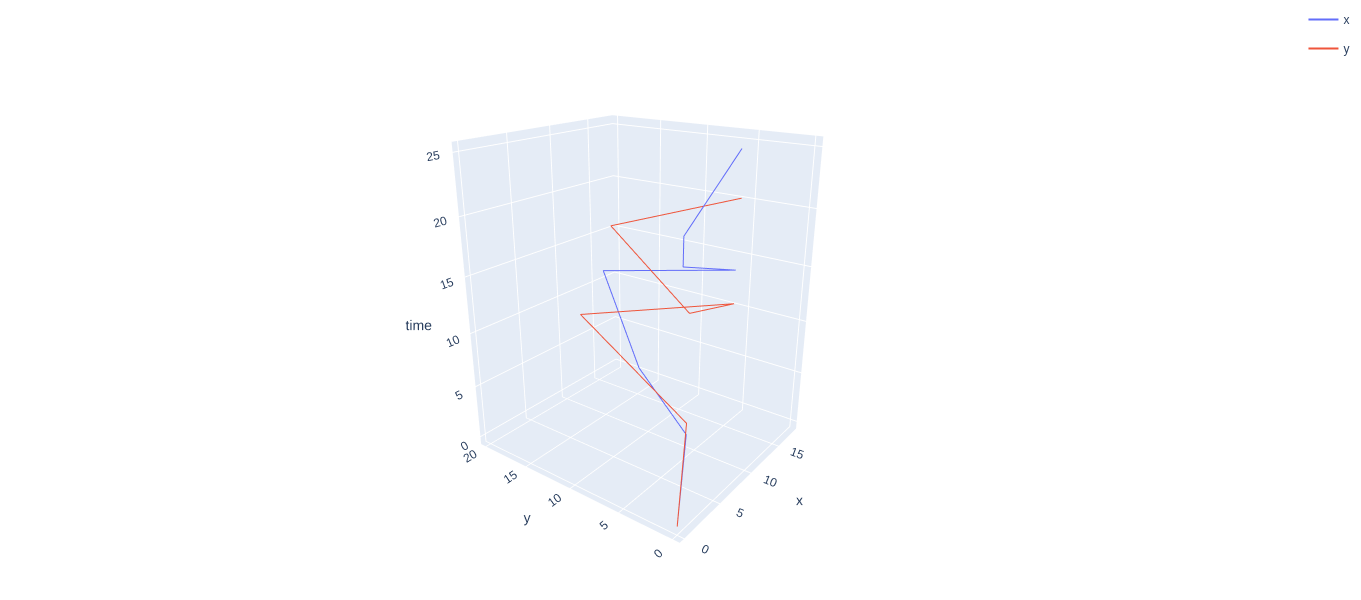

In [27]:
base_fig = make_traj_3d(plotting_data, calculate_col=False, calculate_scol=False, save_path="figures/plotly_trajectory.pdf")
base_fig.show()

In [28]:
col_fig = make_traj_3d(plotting_data)
scol_fig = make_traj_3d(plotting_data, calculate_scol=True)

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



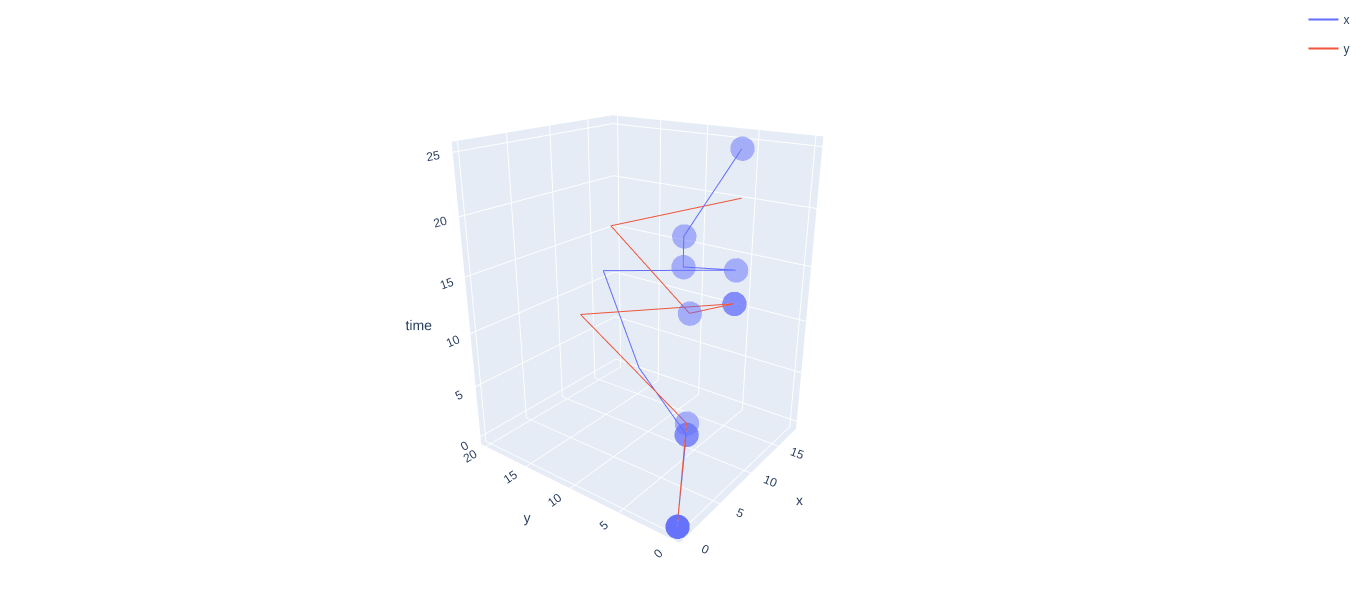

In [29]:
scol_fig.show()

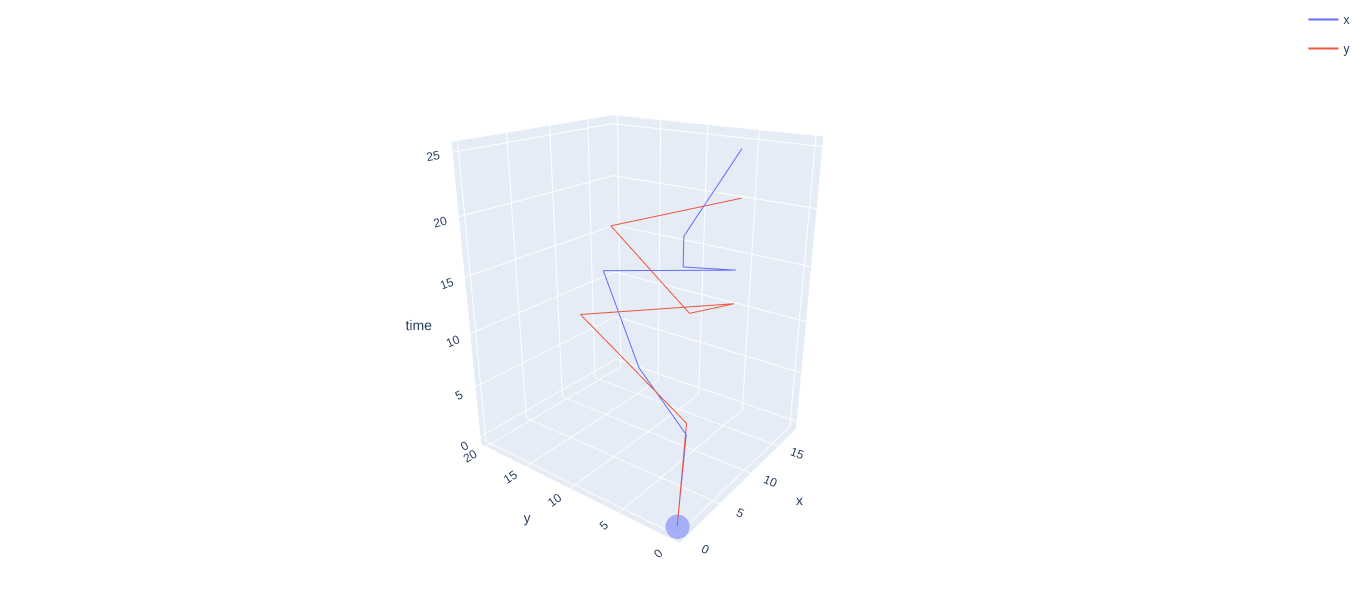

In [30]:
col_fig.show()